# visualize severity of predictions in histogram

In [ ]:
import os
import sys
import pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import datasets

sys.path.append('../')
from utils.directory import load_config

/home/wsl2021/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## input methods and set dataset to eval

In [2]:
methods = [
    'CLIP', 'CRM', 'CuPL', 
    'VCD', 'HieC', 'HieT',
    'Ours', 
]

dataset = 'imagenet'
partition = 'test'

## datasets 

In [3]:
config_path = '../data_paths.yml'
dataset_dir = load_config(config_path)[dataset]
dataset_dir = os.path.join(dataset_dir, partition)
eval_dataset = datasets.ImageFolder(
    root=dataset_dir, 
    transform=None,
)


def get_name(name_tag):
    return name_tag.replace('_', ' ').lower().split('@')[0]

def name_preprocessing(classnames):
    classnames = [get_name(name) for name in classnames]
    return  classnames


classnames = eval_dataset.class_to_idx
classnames = name_preprocessing(classnames)

## hierarchical distance

In [4]:
class DistanceDict(dict):
    """
    Small helper class implementing a symmetrical dictionary to hold distance data.
    """

    def __init__(self, distances):
        self.distances = {tuple(sorted(t)): v for t, v in distances.items()}

    def __getitem__(self, i):
        if i[0] == i[1]:
            return 0
        else:
            return self.distances[(i[0], i[1]) if i[0] < i[1] else (i[1], i[0])]

    def __setitem__(self, i):
        raise NotImplementedError()


def load_hie_distance(dataset, data_dir):
    if dataset == 'food-101':
        fname = os.path.join(data_dir, dataset, 'food101_hdist_from_ChatGPT.pkl')
    elif dataset == 'ucf-101':
        fname = os.path.join(data_dir, dataset,'UCF101_hdist_from_chatgpt_and_manual.pkl')
    elif dataset == 'cub-200':
        fname = os.path.join(data_dir, dataset, "CUB200_hdist_from_flamingo.pkl")
    elif dataset == 'sun-324':
        fname = os.path.join(data_dir, dataset, 'SUN324_hdist.pkl')
    elif dataset == 'imagenet':
        fname = os.path.join(data_dir, dataset, 'imagenet_hdist_cupl_vcd.pkl')
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    with open(fname, 'rb') as f:
        return DistanceDict(pickle.load(f))


data_dir = '../trees'
hdist = load_hie_distance(dataset, data_dir)

## loading prediction results

In [ ]:
def load_prediction_results(method, dataset, partition):
    prompt = None
    inference = 'flat'
    if method in ['CLIP', 'CRM']:
        prompt = 'clip'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    elif method == 'CuPL':
        prompt = 'cupl'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    elif method == 'VCD':
        prompt = 'vcd'
        inference = 'vcd'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    elif method == 'HieC': # hiecomp + cluster
        lambda_dict = {
            'food-101': '0.3', 'ucf-101': '0.7', 
            'cub-200': '0.7', 'sun-324': '0.6', 'imagenet': '0.6'
        }
        lamb = lambda_dict[dataset]
        prompt = 'hiec'
        inference = f'hie-{lamb}-lambda'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    elif method == 'HieT': # hiecomp + tree
        lambda_dict = {
            'food-101': '0.5', 'ucf-101': '0.3', 
            'cub-200': '0.4', 'sun-324': '0.3', 'imagenet': '0.3'
        }
        lamb = lambda_dict[dataset]
        prompt = 'hiet'
        inference = f'hie-{lamb}-lambda'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    elif method == 'Ours':
        prompt = 'ours-full'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    else:
        raise NotImplementedError(f'method: {method} not implemented')

    
    pred_res_path = os.path.join(f'../results-{partition}/{dataset}', fname)
        
    with open(pred_res_path, 'rb') as f:
        pred_res = pickle.load(f)
    print(f'loading inference results at {pred_res_path}')
    gt = pred_res['gt']
    pred = pred_res['pred_crm'] if method == 'CRM' else pred_res['pred']
    return gt, pred

## evaluation - utils

In [6]:
def evaluation(classnames, hdist, gt, pred):
    
    N_samples = len(gt)

    # overall top1 accuracy
    acc = np.sum(pred==gt) / N_samples

    # overall hierarchical distance @ 1
    pred_hdist = np.zeros([N_samples,])
    
    for i in tqdm(range(N_samples), total=N_samples):
        class_id_gt = gt[i]
        class_id_pred = pred[i]

        pred_hdist[i] = hdist[(classnames[class_id_gt], classnames[class_id_pred])]

    avg_hdist = np.mean(pred_hdist)
    mistake_id = np.where(pred_hdist!=0)[0]
    norm_mistake = len(mistake_id)
    avg_severity = np.sum(pred_hdist[mistake_id]) / norm_mistake
    
    print('--------------------------------')
    print(f'Top-1: {acc*100:.2f}%')
    print(f'Severity: {avg_severity: .2f}')
    print(f'HieDist@1: {avg_hdist: .2f}')
    print('--------------------------------')
    return pred_hdist[mistake_id]

## evaluation of different methods -> generate collection of prediction severities

In [7]:
severity_dict = dict()

for method in methods:
    gt, pred = load_prediction_results(method, dataset, partition)
    print(f'eval "{method}" on {partition} set of {dataset}:')
    sevs = evaluation(classnames, hdist, gt, pred)
    severity_dict[method] = sevs

loading inference results at ../results-test/imagenet/flat-inf-clip-prompt.pkl
eval "CLIP" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2045901.95it/s]


--------------------------------
Top-1: 76.58%
Severity:  5.46
HieDist@1:  1.28
--------------------------------
loading inference results at ../results-test/imagenet/flat-inf-clip-prompt.pkl
eval "CRM" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2119322.06it/s]


--------------------------------
Top-1: 76.46%
Severity:  5.39
HieDist@1:  1.27
--------------------------------
loading inference results at ../results-test/imagenet/flat-inf-cupl-prompt.pkl
eval "CuPL" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2239846.85it/s]

--------------------------------
Top-1: 76.53%
Severity:  5.42
HieDist@1:  1.27
--------------------------------


loading inference results at ../results-test/imagenet/vcd-inf-vcd-prompt.pkl
eval "VCD" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2091075.73it/s]


--------------------------------
Top-1: 76.76%
Severity:  5.45
HieDist@1:  1.27
--------------------------------
loading inference results at ../results-test/imagenet/hie-0.6-lambda-inf-hiec-prompt.pkl
eval "HieC" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 1761719.24it/s]

--------------------------------
Top-1: 68.46%
Severity:  7.11
HieDist@1:  2.24
--------------------------------


loading inference results at ../results-test/imagenet/hie-0.3-lambda-inf-hiet-prompt.pkl
eval "HieT" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 1991282.80it/s]

--------------------------------
Top-1: 68.65%
Severity:  7.09
HieDist@1:  2.22
--------------------------------


loading inference results at ../results-test/imagenet/flat-inf-ours-full-prompt.pkl
eval "Ours" on test set of imagenet:


100%|████████████████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2071948.14it/s]

--------------------------------
Top-1: 77.12%
Severity:  5.38
HieDist@1:  1.23
--------------------------------


## plot histogram util
- reference: https://stackoverflow.com/questions/44906202/plot-multiple-bars-in-matplotlib
- all bins are [,) except for the right most bin: [,]

In [8]:
def histogram_plots(methods, severity_dict, hdist, classnames, dataset):
    hdist_max = -1
    for a, b in itertools.combinations(classnames, 2):
        hd = hdist[(a,b)]
        hdist_max = max(hdist_max, hd)
    print(f'{dataset}, max hdist is {hdist_max}')
    bins = [x for x in range(1, hdist_max + 2)] # need right most bin edge
    colors = [
    'red', 'green', 'purple',
    'orange', 'gray', 'hotpink',
    'blue',
    ]
    colors = colors[:len(methods)]

    if dataset == 'imagenet':
        fig = plt.figure(figsize=(18,4))  # imagenet size
    else:
        fig = plt.figure(figsize=(9,4))
        
    plt.hist([h for _, h in severity_dict.items()], 
             bins=bins, align='left',label=methods, 
             alpha=0.6, color=colors, density=False)
    plt.xticks(bins[:-1], bins[:-1])
    plt.xlabel('mistake severity', fontsize=16)
    plt.ylabel('# of misclassifications', fontsize=16)
    if dataset == 'food-101':
        plt.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.6, 0.0, 0.0, 1.0)) # food-101 adjust
    else:
        plt.legend(loc='upper center', fontsize=12)
    return fig

imagenet, max hdist is 13


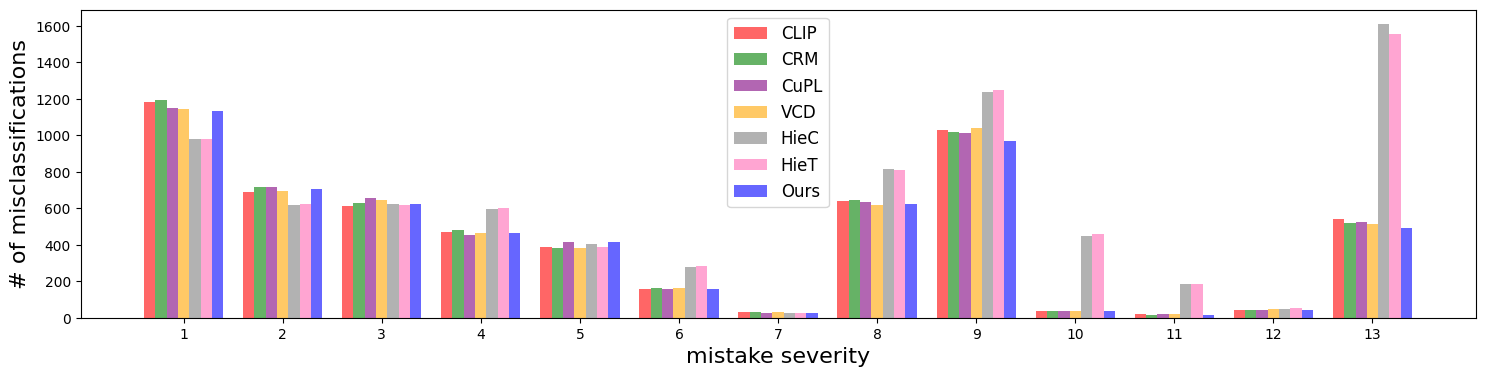

In [9]:
fig = histogram_plots(methods, severity_dict, hdist, classnames, dataset)

In [12]:
save_dir = '../assets'
if not os.path.exists(save_dir): os.makedirs(save_dir)
save_path = f'{save_dir}/hist_of_severity_{dataset}'
fig.savefig(save_path)
print(f'save histogram figure at {save_path}')

save histogram figure at ../assets/hist_of_severity_imagenet
